In [42]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from topicpy.hsbmpy import get_max_available_L
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
directory = "/home/jovyan/work/phd/topics/datasets/gtexall/"
algorithm = "topsbm"
L=get_max_available_L(directory, algorithm)-1
os.chdir(directory)

In [141]:
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L), index_col=1).drop("i_doc", 1)
print("Working with", df_topics.shape[1],"topics")
df_files = pd.read_csv("files.dat", index_col=0).reindex(index=df_topics.index)
df_files.head(2)

Working with 101 topics


,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
doc,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,0.0,B1,"2 pieces, ~15% vessel stroma, rep delineated",6.8,Adipose Tissue,Adipose - Subcutaneous,0002190,1214.0,1125.0,BP-43693,...,14648800.0,11999300.0,0.003158,14669500.0,50.0354,0.003105,0.994740,NaN,0.0,50.1944
GTEX-1117F-0426-SM-5EGHI,0.0,B1,"2 pieces, !5% fibrous connective tissue, delin...",7.1,Muscle,Muscle - Skeletal,0011907,1220.0,1119.0,BP-43495,...,13191500.0,11550200.0,0.003968,13340500.0,50.2809,0.006995,0.995041,NaN,0.0,49.9455


In [142]:
df_topics["tissue"]=df_files["SMTS"]
df_tissues = df_topics.groupby("tissue").mean().transpose()
correlations = df_tissues.corr()
classes = df_tissues.columns

<ipython-input-153-af34e792b4c1>:23: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


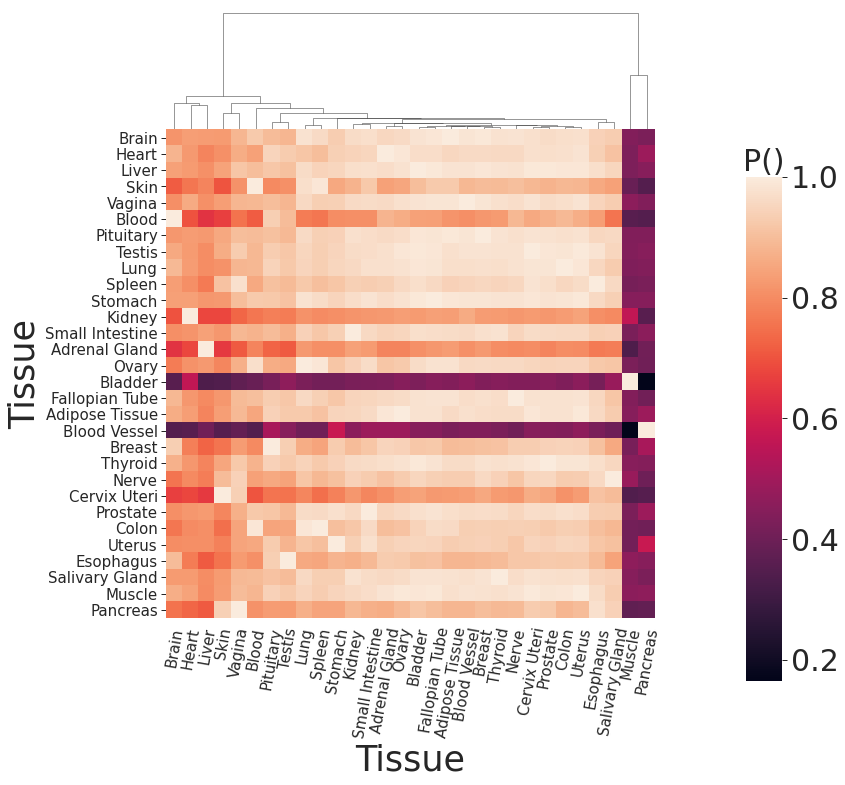

In [153]:
cm = sns.clustermap(correlations, 
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=True, 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    annot=False,
                    cbar_pos=(0.99,0.05,0.05,0.7))
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("Tissue", fontsize=35, rotation=90)
ax.set_yticklabels(labels=classes[cm.dendrogram_col.reordered_ind], rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes[cm.dendrogram_col.reordered_ind], rotation=80)
ax.set_xlabel("Tissue",fontsize=35)
ax.tick_params(labelsize=15)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()
cm.savefig(f"topic_correlation_{algorithm}_level{L}.pdf")

plt.show()

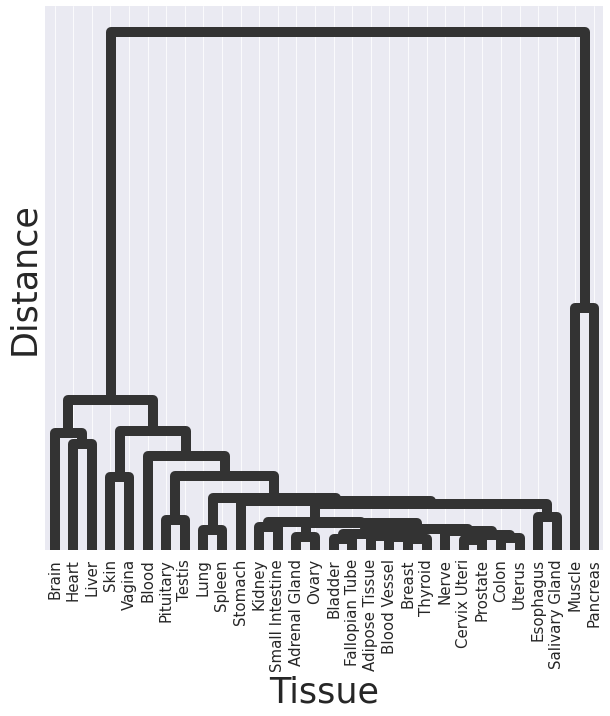

In [156]:
fig,ax = plt.subplots(figsize=(10,10))
cm.dendrogram_col.rotate=False
cm.dendrogram_col.plot(ax, {"linewidths":10})
ax.set_ylabel("Distance", fontsize=35, rotation=90)

ax.set_xticks(np.linspace(5, len(classes)*10-5, len(classes)))
ax.set_xticklabels(labels=classes[cm.dendrogram_col.reordered_ind], rotation=90)
ax.set_xlabel("Tissue",fontsize=35)
ax.tick_params(labelsize=15)
cm.savefig(f"topic_correlation_{algorithm}_level{L}.pdf")

In [132]:
ax.get_xticks()

array([], dtype=float64)